# Binarization and Connected Component Analysis
This notebook explains some basic image processing concepts.  We will work only on grayscale images today, because we don't need the additional complication of colors.

## Preparation

In [1]:
import matplotlib.pyplot as plt

# plots directly in the notebook
%matplotlib inline 

# make figures larger
plt.rcParams["figure.figsize"] = (10,10)

# if you have a high-dpi monitor
#%config InlineBackend.figure_format = 'retina' 

import ipywidgets as widgets

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


### Load and display a grayscale image

(303, 384)
float64


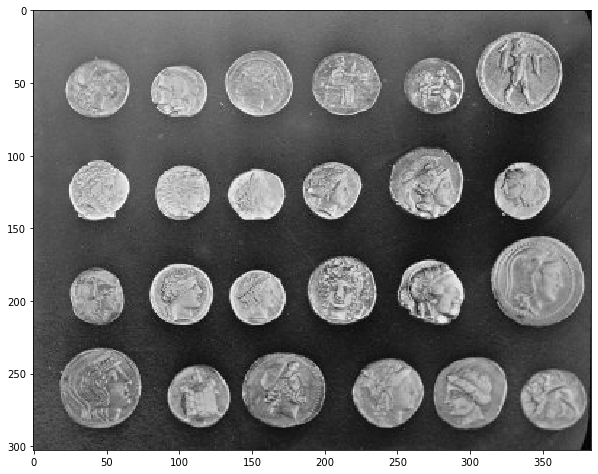

In [3]:
import numpy as np
import skimage
import skimage.data
import skimage.io
im = skimage.data.coins()
im = skimage.color.rgb2gray(im)
im = skimage.img_as_float(im) # make sure our image is floating point in range [0,1]
# to read from a file: skimage.io.imread("myimage.png")
print(im.shape)
print(im.dtype)
plt.imshow(im,cmap="gray")

## Binarizing an image
We can obtain a binary image by _thresholding_ a grayscale image.  A binary image is often called a _mask_.

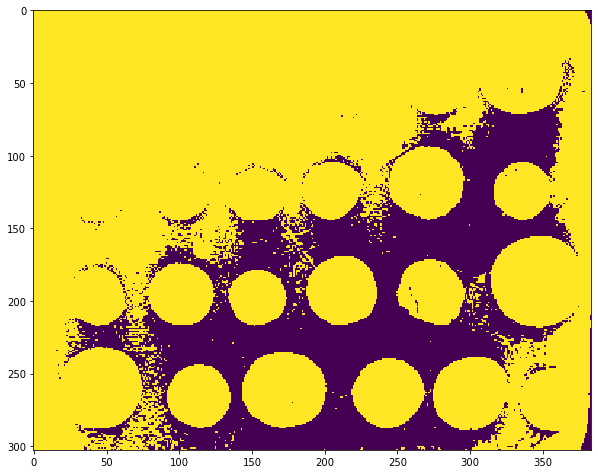

In [4]:
mask = im > 0.2 # bright pixels will be True in the mask, others will be False 
plt.imshow(mask)

Of course, the result depends on the threshold. Find a good threshold to segment this specific image.

In [5]:
@widgets.interact(threshold = (0,1,0.01))
def f(threshold):
    mask = im > threshold
    plt.imshow(mask)

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

$0.50$ sounds like a good threshold for this image, but note that the approach does not segment every coin perfectly.

## Connected Component Analysis

Separating and analyzing the "islands" of `True` pixels in a binary image is called _connected component analysis_ ([documentation](http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html)).

In [6]:
import skimage.measure
labels = skimage.measure.label(mask)
print(labels.shape, labels.dtype)
print("Unique values in labels:", np.unique(labels))

(303, 384) int64
Unique values in labels: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 

`labels` contains one different number for each "island" of `True` in `mask`, and $0$ for pixels that are `False` in mask.  These islands are called _connected components_.

In [7]:
@widgets.interact(label = list(np.unique(labels)))
def f(label):
    print(f"The connected component with label {label} contains {np.sum(labels == label)} pixels")
    plt.imshow(labels == label)

interactive(children=(Dropdown(description='label', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

The `regionprops` ([documentation](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops)) function can compute properties for each connected component.  Some important properties are the following:

- `area : int` Number of pixels of the region.
- `bbox : tuple` Bounding box `(min_row, min_col, max_row, max_col)`. Pixels belonging to the bounding box are in the half-open interval `[min_row; max_row)` and `[min_col; max_col)`.
- `centroid : array` Centroid coordinate tuple `(row, col)`.
- `convex_area : int` Number of pixels of convex hull image, which is the smallest convex polygon that encloses the region.
- `label : int` The label in the labeled input image.

Let's select only the large regions

In [8]:
regions = skimage.measure.regionprops(labels)
large_regions = [r for r in regions if r.area > 100]
print(f"There are {len(large_regions)} large regions")

There are 7 large regions


And let's now draw all bounding boxes for the large regions over the original image

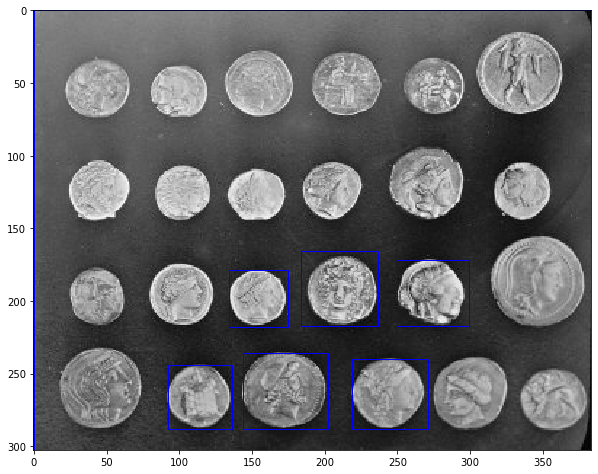

In [9]:
import matplotlib.patches as patches
fig, ax = plt.subplots()
ax.imshow(im, cmap="gray")
for r in large_regions:
    (min_row, min_col, max_row, max_col) = r.bbox
    width = max_col - min_col
    height = max_row - min_row
    rect = patches.Rectangle((min_col,min_row),width,height,
                             linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

## Exercises
### Exercise 1
The approach above depends on the choice of two parameters: the threshold, and the minimum size of the connected component.  Refactor the code above in order to tweak both parameters interactively and check how the results are affected by them.   Can you find a setting for which you identify all and only the coin regions?

In [10]:
@widgets.interact(threshold = (0,1,0.01), minsize = (10,500))
def f(threshold, minsize):
    mask = im > threshold
    labels = skimage.measure.label(mask)
    regions = skimage.measure.regionprops(labels)
    large_regions = [r for r in regions if r.area > minsize]
    
    # plot the results
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.imshow(mask)
    ax2.imshow(im, cmap="gray")
    for r in large_regions:
        (min_row, min_col, max_row, max_col) = r.bbox
        width = max_col - min_col
        height = max_row - min_row
        rect = patches.Rectangle((min_col,min_row),width,height,
                                 linewidth=1,edgecolor='b',facecolor='none')
        ax2.add_patch(rect)

interactive(children=(FloatSlider(value=0.0, description='threshold', max=1.0, step=0.01), IntSlider(value=255…

Threshold: 0.53 and Minsize: 200 seems like a good fit

### Exercise 2
Write a function that, given an image like the image above, crops each coin and saves it to a separate image file, named `00001.png`, `00002.png`, and so on. Use [`skimage.io.imsave(...)`](http://scikit-image.org/docs/dev/api/skimage.io.html#skimage.io.imsave).

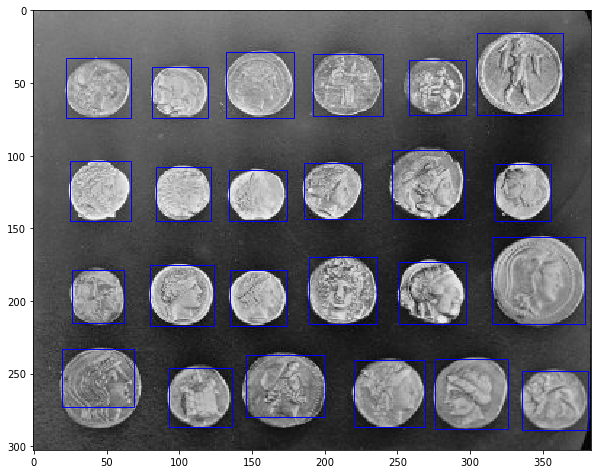

In [23]:
mask = im > 0.53
labels = skimage.measure.label(mask)
regions = skimage.measure.regionprops(labels)
large_regions = [r for r in regions if r.area > 200]
fig, ax = plt.subplots()
ax.imshow(im, cmap="gray")
for r in large_regions:
    (min_row, min_col, max_row, max_col) = r.bbox
    width = max_col - min_col
    height = max_row - min_row
    rect = patches.Rectangle((min_col,min_row),width,height,
                             linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

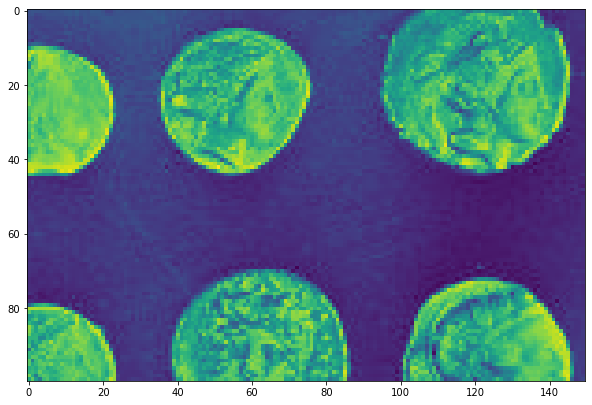

In [16]:
plt.imshow(im[100:200,150:300])

In [26]:
im_int = skimage.img_as_uint(im)
i = 1
for r in large_regions:
    (min_row, min_col, max_row, max_col) = r.bbox
    print('{:04d}.png'.format(i))
    skimage.io.imsave('coins/{:04d}.png'.format(i), im_int[min_row:max_row, min_col:max_col])
    i += 1

0001.png
0002.png
0003.png
0004.png
0005.png
0006.png
0007.png
0008.png
0009.png
0010.png
0011.png
0012.png
0013.png
0014.png
0015.png
0016.png
0017.png
0018.png
0019.png
0020.png
0021.png
0022.png
0023.png
0024.png


### Exercise 3
Adapt your function to work on images similar to the one found at the URL below (tip: you can load it directly using `skimage.io.imread(url)`).  Note that now coins are dark on a bright background.

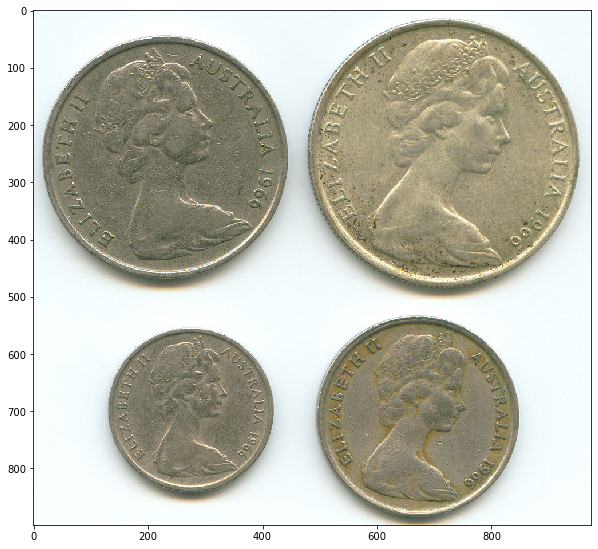

In [27]:
im = skimage.io.imread("https://upload.wikimedia.org/wikipedia/commons/thumb/0/04/Aus_coins_queen_elizabeth_1966.jpg/975px-Aus_coins_queen_elizabeth_1966.jpg")
plt.imshow(im)

### Exercise 4 (difficult)

Write a function to count the grains of rice in the image found at [this link](https://www.mathworks.com/help/examples/images/win64/NonuniformIlluminationExample_01.png), and return the largest and smallest grain size in pixels.

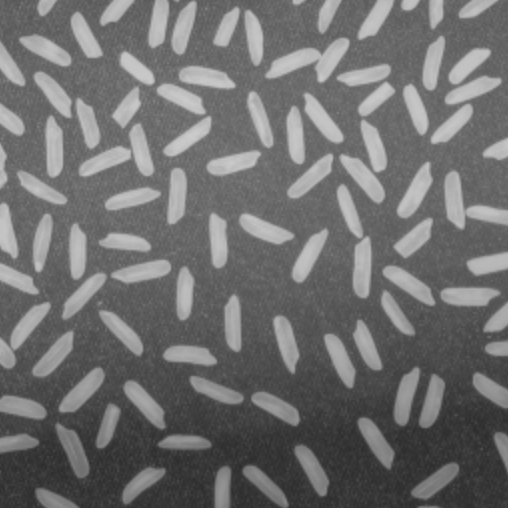

Note that thresholding is difficult due to uneven illumination (the bottom part is darker); try it!  One possible solution is to look for the darkest intensity in each row and subtract that value from all values in that row.  The code below shows an example.

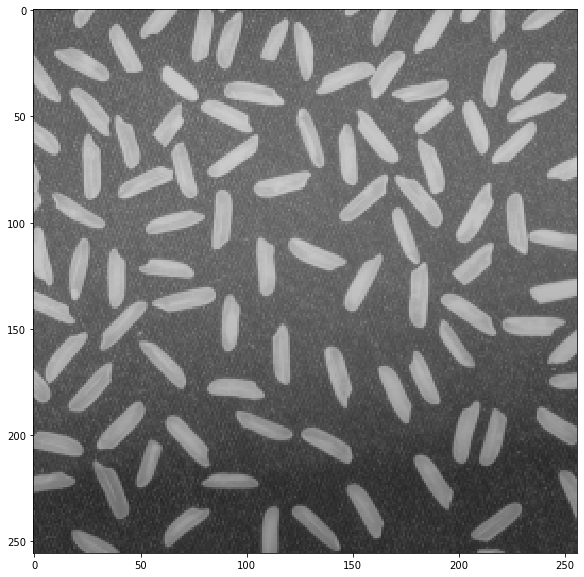

In [32]:
im = skimage.io.imread("https://carmbrustdotcom.files.wordpress.com/2016/10/rice.png")
im = skimage.img_as_float(im)
plt.imshow(im, cmap="gray", vmin=0, vmax=1)

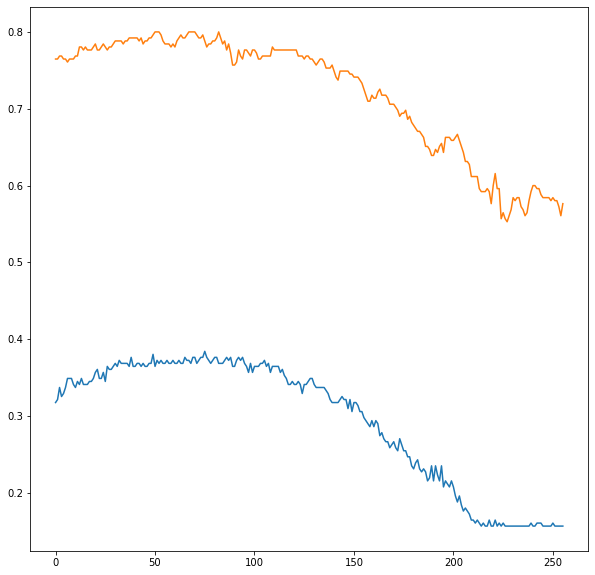

In [33]:
plt.plot(np.min(im, axis=1))
plt.plot(np.max(im, axis=1))
plt.show()

In [34]:
print(im)

[[0.47843137 0.36078431 0.37254902 ... 0.39607843 0.39215686 0.36078431]
 [0.38823529 0.38823529 0.4        ... 0.41176471 0.36470588 0.36470588]
 [0.38039216 0.41960784 0.40392157 ... 0.37647059 0.37254902 0.40392157]
 ...
 [0.2        0.22745098 0.18039216 ... 0.24705882 0.19215686 0.21568627]
 [0.20392157 0.20392157 0.20784314 ... 0.25490196 0.20392157 0.21176471]
 [0.23137255 0.2        0.20392157 ... 0.25490196 0.18039216 0.16470588]]


In [39]:
@interact(thresh=widgets.FloatSlider(min=0.0, max=0.5, step=0.01, value=0.2))
def threshold(thresh):
    im_thresh = []
    for line in im:
        im_thresh.append([pixel if pixel > np.min(line) + thresh else float(0) for pixel in line])
    plt.imshow(im_thresh, cmap="gray", vmin=0, vmax=1)
    plt.show()


interactive(children=(FloatSlider(value=0.2, description='thresh', max=0.5, step=0.01), Output()), _dom_classe…

In [ ]:
plt.plot(np.min(im,axis=1))
plt.xlabel("row number")
plt.ylabel("minimum image intensity")